In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat
import cv2
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
from torch.cuda.amp import GradScaler

In [5]:
import seaborn as sns
import albumentations as A
from tqdm.notebook import tqdm

ModuleNotFoundError: No module named 'albumentations'

## Load DataFrame with Pathing

In [6]:
df = pd.read_csv('data/POC_imagedata.csv')

In [7]:
df.head()

,Country,Latitude,Longitude,Pano_Id,Path
0,Spain,36.477286,-5.880578,mnPCQWYwG-MIUV64ybl23g,data/images/Spain/0000/
1,Spain,37.600117,-4.341563,cXqaOBEMHANps9ZENoLozw,data/images/Spain/0001/
2,Spain,42.870488,-1.381516,RHuZZGXpb4levD1LK8Wtsw,data/images/Spain/0002/
3,Spain,41.296693,-3.603524,si-40KyaaKHFGdvy12nSIg,data/images/Spain/0003/
4,Spain,39.024927,-3.977601,wniI8AxaJ2gBC7q1GjV7GQ,data/images/Spain/0004/


In [8]:
#df = df.sample(1000)

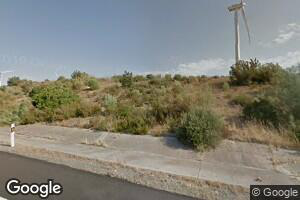

In [9]:
Image.open(df.Path.iloc[0] + 'N.jpg')

## Create Train / Validation Sets

In [10]:
train, val = train_test_split(df, test_size=0.20, stratify=df.Country.values)

In [11]:
train.shape

(2400, 5)

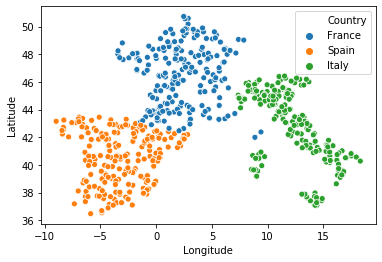

In [12]:
sns.scatterplot(x='Longitude', y='Latitude', data=val, hue='Country')

## Dataset

In [13]:
MAPPING = {'Spain': 0, # Spain
           'France': 1, # France
           'Italy': 2} # Italy

In [14]:
def img_to_np(fullpath):
    x = cv2.imread(fullpath).astype(np.uint8)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

In [15]:
def stitch_panos(path):
    return np.concatenate([img_to_np(path + direction + '.jpg') for direction in 'NESWN'], axis=1)

In [16]:

def get_xy(path, y_map):
    x = stitch_panos(path)
    y = y_map[path[12: 12 + path[12:].find('/')]]
    return x, y

In [17]:
x, y = get_xy(train.Path.iloc[0], MAPPING)

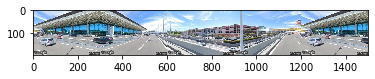

In [18]:
plt.imshow(x)

In [19]:
x.shape, y

((200, 1500, 3), 2)

#### Data Augmentation Functions

In [20]:
transforms = A.Compose([
        A.RandomCrop(height=150, width=1200),
        A.HorizontalFlip(p=0.5),
        A.GaussNoise(p=0.15),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=12.5, p=0.25),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        A.Normalize()
    ])

no_transforms = A.Compose([
        A.RandomCrop(height=150, width=1200),
        A.Normalize()
])

NameError: name 'A' is not defined

In [21]:
def min_max_scale(img):
    max_, min_ = img.max(), img.min()
    return (img - min_) / (max_ - min_)

(150, 1200, 3)


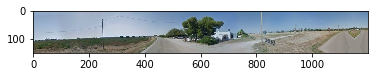

In [19]:
aug = transforms(image=x)['image']
print(aug.shape)
plt.imshow(min_max_scale(aug))

(150, 1200, 3)


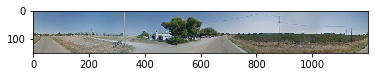

In [20]:
no_aug = no_transforms(image=x)['image']
print(no_aug.shape)
plt.imshow(min_max_scale(no_aug))

In [21]:
class GeoDataset(Dataset):
    def __init__(self, df, transform=False):
        self.paths = [p for p in df.Path.values]
        self.transform = transform
        self.random_init()
        
    def random_init(self):
        self.random = np.random.rand(len(self.paths), 4)
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        x, y = get_xy(self.paths[idx], MAPPING)
        
        if self.transform:
            x = transforms(image=x)['image']
        else:
            x = no_transforms(image=x)['image']
        
        x = np.rollaxis(x, 2)
        return x, y

In [22]:
train_ds = GeoDataset(train, transform=True)
valid_ds = GeoDataset(val)

In [23]:
x, y = train_ds[1]
x.shape, y

((3, 150, 1200), 0)

## Model

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 128), nn.ReLU(), 
                                        nn.Dropout(0.3), nn.Linear(128, 3))
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(self.dropout(x))
        return x

In [25]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        loss = F.cross_entropy(out, y, reduction='sum')
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [26]:
def train_epochs(model, train_dl, valid_dl, max_lr=0.001, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    pbar = tqdm(total=iterations)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer2(model, lrs[0])
    scaler = GradScaler()
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            lr = lrs[idx]
            update_optimizer2(optimizer, [lr/20, lr/10, lr])
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            optimizer.zero_grad()
            with autocast():
                out = model(x)
                loss = F.cross_entropy(out, y, reduction='sum')
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            #loss.backward()
            #optimizer.step()
            total += batch
            sum_loss += loss.item()
            idx += 1
            pbar.update()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.75:
                path = "data/models/model_resnet18_stitch_loss_{0:.0f}.pth".format(100*val_acc)
                save_model(model, path)
                print(path)
    return path

In [27]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [28]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [29]:
def create_optimizer2(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/50},
              {'params': model.features2.parameters(), 'lr': lr0/20},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay=5e-5)

def update_optimizer2(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [30]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [31]:
model = Net().cuda()

In [32]:
val_metrics(model, valid_dl)

(1.115453077952067, 0.3333333333333333)

In [33]:
best_path = train_epochs(model, train_dl, valid_dl, max_lr=0.00008, epochs=30)

NameError: name 'GradScaler' is not defined

In [ ]:
best_path

## Prediction Evaluation

In [ ]:
best_model = Net().cuda()
load_model(best_model, best_path)

In [ ]:
val.head()

In [ ]:
rev_map = {v: k for k,v in MAPPING.items()}
rev_map

In [ ]:
preds = []
with torch.no_grad():
    best_model.eval()
    for x, y in valid_dl:
        out = best_model(x.cuda().float())
        _, pred = torch.max(out, 1)
        pred = pred.cpu().detach().numpy()
        preds += [rev_map[p] for p in pred]

In [ ]:
val['predictions'] = preds

In [ ]:
val.head()

In [ ]:
sns.scatterplot(x='Longitude', y='Latitude', data=val, hue='predictions')

In [ ]:
(val.Country == val.predictions).sum() / len(val)